# `tf.summary.FileWriter`クラス
FileWriterオブジェクトを生成すると同時に、新規のイベントファイルを作成する。
※tf.summary.FileWriter()を実行すると以下の初期化メソッドが呼ばれる。
```python
__init__(
    logdir,
    grapha=None,
    max_queue=10,
    flush_secs=120,
    grapha_def=None,
    filename_suffix=None
)
```

| 引数名 | 説明 |
|:--------:|:------|
| `logdir` | イベントファイルが書き込まれるフォルダを指定する。指定した場所に該当するフォルダがない場合は、フォルダも同時に作成される。 |
| `graph` | オプション。データフローグラフをイベントログとして追加する場合は、`grapha=Sessionオブジェクト.graph`を指定する。 |
| `max_queue`  | イベントログ(サマリ)の上限数を指定する。デフォルトは10。 |
| `flush_secs` | イベントログを内臓ディスクに書き込む頻度。デフォルトは120。 |
| `graph_def` | データフローグラフを引数として指定する場合に使用する。 |
| `filename_suffix` | イベントファイルの名前に接尾辞を付ける場合に使用する。 |

## ブラウザベースで動作するTensorBoard

 - TensorBoard : 予測値(例えば、時系列データの推移)をグラフ化するためのTensorFlowの可視化ツール
 - 起動方法 :
     1. Anacondaプロンプトで「tensorboard」と入力して起動
     2. プログラム内の任意の箇所でTensorBoard用のイベントログ(FileWriterオブジェクト)を生成し、そのログを起動時に読み込ませる

### TensorBoardによる可視化の手順

**データフローグラフでの処理**
 1. データフローグラフの中にイベントログを取得するためのopノードを作成
 2. イベントログ(のopノード)をマージ(1つにまとめる)ためのopノードを作成

**セッションでの処理**
 3. FileWriterオブジェクトを生成してイベントファイルの出力先を指定する
 4. イベントログを取得するタイミングで②で作成したイベントログをマージするopノードを実行
 5. ④の結果をFileWriterオブジェクトに追加する

例 ) 実測値と指数値をログとして記録する。<br>
指数平滑法:
$$
\begin{eqnarray}
\hat {y}_{t} & = & \alpha y_{t-1} + (1 - \alpha) \hat {y}_{t-1}\\
& = & \hat {y}_{t-1} + \alpha \left( y_{t-1} - \hat {y}_{t-1} \right)
\end{eqnarray}
$$

 - $\hat {y}_{t}$ : $t$の予測値
 - $y_{t}$ : 直前($t - 1$)の実測値
 - $\hat {y}_{t-1}$ : 直前($t-1$)の予測値
 - $0 < \alpha < 1$

In [2]:
import tensorflow as tf
import numpy as np

# --- データフローグラフの作成 ---
nd_data = np.random.normal(10, 1, 100)     # 平均10, 標準偏差1の正規分布に従う乱数を100個生成するノード
nd_alpha = tf.constant(0.05)                         # 定数ノード
nd_y_t_1 = tf.placeholder(tf.float32)          # 実測値y_{t-1}を保持するプレースホルダーのノード
nd_predicted_y_t_1 = tf.Variable(0.0)        # 予測値\hat {y}_{t-1}を保持する変数

# 変数の初期化
nd_init = tf.global_variables_initializer()

# 指数平滑法による予測値を求めるノード
nd_predict = nd_predicted_y_t_1 + nd_alpha * (nd_y_t_1 - nd_predicted_y_t_1)

# 1. データフローグラフの中にイベントログを取得するためのopノードを作成
nd_y_t_1_log = tf.summary.scalar("y_t_1", nd_y_t_1)
nd_predicted_y_t_1_log = tf.summary.scalar("predicted_y_t_1", nd_predicted_y_t_1)

# 2. イベントログ(のopノード)をマージ(1つにまとめる)ためのopノードを作成
nd_merge = tf.summary.merge([nd_y_t_1_log, nd_predicted_y_t_1_log])

#### `tf.summary.scalar()` : 単一のスカラ値を含む(イベントログ)を出力する
サマリ(イベントログ)を生成する。戻り値は、string型の文字列を格納するopノード(Tensorオブジェクト)です。

```python
tf.summary.scalar(
    name,
    tensor,
    collections=None,
    family=None
)
```

| 引数名 | 説明 |
|:--------:|:-------|
| `name` | 生成されたノード(イベントログ)の名前。TensorBoardにおける識別名にもなる。 |
| `tensor` | 単一の値を含む実数値のopノード(Tensorオブジェクト)。 |
| `collections` | グラフコレクションに使用するキーのオプションリスト。新しい集計演算子がこれらのコレクションに追加される。デフォルトは[GraphKeys.SUMMARIES]. |
| `family` | オプション。指定されている場合は、Tensorboardに表示するために使用されるタグ名を制御する要約タグ名の接頭辞として使用される。 |


#### `tf.summary.merge` : 出力されたサマリをマージ(1つにまとめる)する
出力されたサマリをマージする。戻り値は、string型の文字列を格納するopノード(Tensorオブジェクト)。
```python
tf.summary.merge(
    inputs,
    collecions=None,
    name=None
)
```

| 引数名 | 説明 |
|:--------:|:-------|
| `inputs` | 出力されたサマリ(イベントログ)のリスト |
| `collections` | グラフコレクションに使用するキーのオプションリスト。新しい集計演算子がこれらのコレクションに追加される。デフォルトは`[]`(未指定)。 |
| `name` | オペレーションの名前(オプション)。 |

#### `tf.summary.merge_all()`
出力された「すべてのサマリ」をマージする。戻り値は、string型の文字列を格納するopノード(Tensorオブジェクト)。サマリが収集できなかった場合は、Noneを返す。
```python
tf.summary.merge_all(
    key=tf.GraphKeys.SUMMARIES,
    scope=None
)
```

| 引数名 | 説明 |
|:---------|:-----------------|
| `key` | サマリを収集するために使用する。デフォルトは`GraphKeys.SUMMARIES` |
| `scope` | オプション。マージするサマリのスコープを指定する。 |


すべてのイベントログをまとめてマージする。
```python
merged = tf.summary.merge_all()
```

## プログラムを実行してTensorBoardで確認する

In [5]:
# --- セッション部 ---
with tf.Session() as sess:
    sess.run(nd_init)    # initノードを実行して変数を初期化

    writer = tf.summary.FileWriter(
        logdir="logs",            # イベントファイルの保存先
        graph=sess.graph    # データフローグラフを視覚化する
    )

    for i in range(len(nd_data)):
        # イベントログ, 予測値を返す.
        summary_str, predict = sess.run(
                [nd_merge, nd_predict],
                feed_dict={
                    nd_y_t_1: nd_data[i]
                }
            )
        # 更新
        sess.run(tf.assign(nd_predicted_y_t_1, predict))
        
        print('(measured)', nd_data[i], '(predicted)', predict)
        
    writer.close()

(measured) 8.933685903460614 (predicted) 0.44668433
(measured) 9.858327183598368 (predicted) 0.9172665
(measured) 10.2776213749336 (predicted) 1.3852842
(measured) 9.276947254198237 (predicted) 1.7798673
(measured) 7.624782179455551 (predicted) 2.072113
(measured) 11.272463778860958 (predicted) 2.5321305
(measured) 8.30390583741685 (predicted) 2.8207192
(measured) 8.401176254315365 (predicted) 3.0997422
(measured) 9.304854081870575 (predicted) 3.4099977
(measured) 9.842112494879403 (predicted) 3.7316034
(measured) 9.826978299475659 (predicted) 4.036372
(measured) 11.792342118363123 (predicted) 4.4241705
(measured) 9.986427329191038 (predicted) 4.7022834
(measured) 11.03118596914369 (predicted) 5.0187287
(measured) 9.74799662634863 (predicted) 5.2551923
(measured) 9.983387701354301 (predicted) 5.491602
(measured) 9.32657739547628 (predicted) 5.6833506
(measured) 8.00832131845912 (predicted) 5.799599
(measured) 9.467268681470761 (predicted) 5.9829826
(measured) 8.949576162241303 (predict

### TensorBoardの起動
logsフォルダ以下にイベントファイルが作成された。このファイルを読み込ませてTensorBoardを起動する。

```bash
$ tensorboard --logdir=/path/to/log-directory
```
ブラウザからlocalhost:6006を開くとTensorBoardのこんなGUIが表示されるはずです。

![](./imgs/TensorBoardの実行結果.png)

---
# `tf.train.GradientDescentOptimizer`クラス
> 勾配降下アルゴリズムを実装するオプティマイザー(最適化問題を解く機能)を提供するクラス

**`tf.train.GradientDescentOptimizer.__init__()`**

書式: 
```python
__init__(
    learning_rate,
    use_locking=False,
    name='GradientDescent'
)
```

| 引数名 | 説明　|
|:--------|:------|
| `learning_rate` | 学習率 |
| `use_locking` | Trueの場合、更新オペレーションのロックが使用される。 |
| `name` | オペレーション名の接頭辞を指定。デフォルトは、`GradientDescent`。 |

**`GradientDescentOptimizerオブジェクト.minimize()`**
> 引数に指定したコスト関数が最小になる勾配を計算し、パラメータの値を更新する。戻り値は、更新後のパラメータ値のリスト.

書式:
```python
minimize(
    loss,
    global_step=None,
    var_list=None,
    gate_gradients=GATE_OP,
    aggregation_method=None,
    colocate_gradients_with_ops=False,
    name=None,
    grad_loss=None
)
```

| 引数名 | 説明 |
|:--------:|:--------|
| `loss` | 最小化するopノード(Tensorオブジェクト) |
| `global_step` | オプション。更新された後に1ずつ増分する値を代入する変数を指定。 |
| `var_list` | 最小化するための更新時における損失を格納した変数のリスト、またはタプルを指定する。デフォルトで、TRAINABLE_VARIABLESというキー名で収集された変数のリストになる。 |
| `gate_gradients` | オプション。勾配計算における可逆計算の方法を指定。`GATE_NONE`, `GATE_OP`, `GATE_GRAPH`が指定可能で、デフォルトは`GATE_OP`です。 |
| `aggregation_method` | オプション。勾配法の繰り返しによる段階的な変化を集計する方法を指定。`tf.AggregationMethod`クラスで定義する。 |
| `colocate_gradients_with_ops` | オプション。Trueの場合、対応するオペレーション勾配法の繰り返しによる段階的な変化の集計が行われる。 |
| `name` | オプション。実行されるオペレーションの名前を指定する。 |
| `grad_loss` | オプション。勾配法に置ける損失(loss)を保持するTensorオブジェクトを指定 |

## 線形回帰分析による未知の値の予測
回帰モデル:
$$
y = w_{1} x + w_{0}
$$

誤差関数(損失関数):
$$
E\left(w_{1}, w_{0} ;x\right) = \frac {1}{2} \sum _{n=1}^{N}{\left[ y_{n} - \left( w_{1} x_{n} + w_{0} \right) \right]^{2}}
$$

In [27]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt(
        fname='./datasets/sales.csv',
        dtype='int',
        delimiter=',',
        skiprows=1
    )

train_x = data[:, 0]
train_y = data[:, 1]
train_x

array([173, 191, 134, 100, 117, 112,  35,  87, 203,  50,  26, 163, 270,
       160, 160,  60, 199, 237, 215, 145])

In [28]:
# # 前処理
# from sklearn.preprocessing import StandardScaler


# train_x_std = StandardScaler().fit_transform(train_x.reshape(-1, 1))
# train_x_std = train_x_std.reshape(1, -1)[0]
# train_x_std

train_x_std = (train_x - train_x.mean()) / train_x.std()

/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['[IPAexGothic]'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


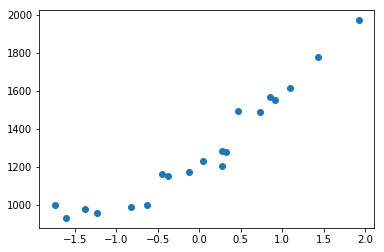

In [34]:
plt.plot(
    train_x_std,
    train_y,
    'o'
)
plt.show()

**データフローグラフの作成**

 - $x, y$の値を繰り返し代入するプレースホルダーのopノード
 - バイアスと重みの値を保持する変数
 - 回帰モデル
 - 回帰モデルを実行するopノード
 - 損失関数のopノード
 - 勾配法による損失関数の最小化を行うopノード
 - 変数を初期化するopノード

In [43]:
import tensorflow as tf


# x, yの値を繰り返し代入するプレースホルダーのopノード
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# バイアスと重みの値を保持する変数
b = tf.Variable(0.0, name="bias")
w = tf.Variable(0.0, name="weights")

# 回帰モデル
def model(X, b, w):
    """
    回帰モデル.

    Paramter
    X : np.array, 標準化されたx
    b : バイアス
    w : 重み
    
    Return
    Tensorオブジェクト
    """
    return tf.add(b, tf.multiply(w, X))


# 回帰モデルを実行するopノード
predicted_y = model(X, b, w)

# 損失関数のopノード
cost = tf.reduce_mean(tf.square(Y - predicted_y))

# 勾配法による損失関数の最小化を行うopノード
LEARNING_RATE = 0.001   # 学習率
train_op = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cost)

# 変数を初期化するopノード
init_op = tf.global_variables_initializer()

In [46]:
# --- セッション部 ---
from tqdm import tqdm


EPOCHS = 300    # 学習を繰り返す回数

with tf.Session() as sess:
    sess.run(init_op)    # 変数を初期化opノードを実行
    for i in tqdm(range(EPOCHS)):
        for (x, y) in zip(train_x_std, train_y):
            sess.run(
                train_op,         # 勾配法のopノードを実行
                feed_dict={    # placeholderをセット
                    X: train_x_std,
                    Y: train_y
                }
            )
            
            # 1回更新ごとのバイアスと重みを出力
            print('({i}), b, w = {b}, {w}'.format(i=i+1, b=sess.run(b), w=sess.run(w)))
    
    learned_w, learned_b = sess.run([w, b])
    print('--- Finish Training ---')
    print('bias = ', learned_b)
    print('weight = ', learned_w)

  3%|▎         | 9/300 [00:00<00:07, 40.51it/s]

(1), b, w = 2.5821001529693604, 0.5524337291717529
(1), b, w = 5.159036636352539, 1.1037626266479492
(1), b, w = 7.730818748474121, 1.6539888381958008
(1), b, w = 10.297456741333008, 2.2031145095825195
(1), b, w = 12.858962059020996, 2.7511420249938965
(1), b, w = 15.41534423828125, 3.2980735301971436
(1), b, w = 17.96661376953125, 3.8439111709594727
(1), b, w = 20.512781143188477, 4.388657093048096
(1), b, w = 23.053855895996094, 4.932313442230225
(1), b, w = 25.589847564697266, 5.47488260269165
(1), b, w = 28.12076759338379, 6.016366481781006
(1), b, w = 30.646625518798828, 6.556767463684082
(1), b, w = 33.16743087768555, 7.096087455749512
(1), b, w = 35.683197021484375, 7.634328842163086
(1), b, w = 38.193931579589844, 8.171493530273438
(1), b, w = 40.699642181396484, 8.707584381103516
(1), b, w = 43.20034408569336, 9.242603302001953
(1), b, w = 45.696044921875, 9.776552200317383
(1), b, w = 48.18675231933594, 10.309432983398438
(1), b, w = 50.67247772216797, 10.84124755859375
(2), 

  5%|▌         | 16/300 [00:00<00:07, 36.82it/s]

(10), b, w = 417.277099609375, 89.27538299560547
(10), b, w = 419.024658203125, 89.6492691040039
(10), b, w = 420.7687072753906, 90.02240753173828
(10), b, w = 422.50927734375, 90.3947982788086
(10), b, w = 424.2463684082031, 90.76644134521484
(10), b, w = 425.97998046875, 91.13734436035156
(11), b, w = 427.7101135253906, 91.50749969482422
(11), b, w = 429.4367980957031, 91.87691497802734
(11), b, w = 431.1600341796875, 92.24559783935547
(11), b, w = 432.87982177734375, 92.61354064941406
(11), b, w = 434.5961608886719, 92.98075103759766
(11), b, w = 436.30908203125, 93.34722137451172
(11), b, w = 438.0185546875, 93.71295928955078
(11), b, w = 439.724609375, 94.07796478271484
(11), b, w = 441.42724609375, 94.44224548339844
(11), b, w = 443.1264953613281, 94.80579376220703
(11), b, w = 444.8223571777344, 95.16861724853516
(11), b, w = 446.5148010253906, 95.53071594238281
(11), b, w = 448.203857421875, 95.89208984375
(11), b, w = 449.8895568847656, 96.25273895263672
(11), b, w = 451.57186

  8%|▊         | 24/300 [00:00<00:07, 36.39it/s]

(18), b, w = 656.763916015625, 140.5130157470703
(18), b, w = 658.032470703125, 140.784423828125
(18), b, w = 659.2985229492188, 141.05528259277344
(18), b, w = 660.56201171875, 141.3256072998047
(18), b, w = 661.822998046875, 141.5953826904297
(18), b, w = 663.0814819335938, 141.8646240234375
(19), b, w = 664.33740234375, 142.13333129882812
(19), b, w = 665.5908203125, 142.40150451660156
(19), b, w = 666.8417358398438, 142.66912841796875
(19), b, w = 668.0901489257812, 142.93621826171875
(19), b, w = 669.3360595703125, 143.20277404785156
(19), b, w = 670.5794677734375, 143.4687957763672
(19), b, w = 671.8204345703125, 143.7342987060547
(19), b, w = 673.0588989257812, 143.999267578125
(19), b, w = 674.2948608398438, 144.26370239257812
(19), b, w = 675.5283813476562, 144.52760314941406
(19), b, w = 676.7593994140625, 144.79098510742188
(19), b, w = 677.9879760742188, 145.0538330078125
(19), b, w = 679.214111328125, 145.316162109375
(19), b, w = 680.4378051757812, 145.5779571533203
(19),

 10%|▉         | 29/300 [00:00<00:07, 37.16it/s]

(25), b, w = 811.801513671875, 173.682861328125
(25), b, w = 812.760009765625, 173.88792419433594
(25), b, w = 813.7166137695312, 174.0925750732422
(25), b, w = 814.6712646484375, 174.2968292236328
(25), b, w = 815.6240234375, 174.50067138671875
(25), b, w = 816.5748901367188, 174.7041015625
(26), b, w = 817.5238647460938, 174.90711975097656
(26), b, w = 818.470947265625, 175.1097412109375
(26), b, w = 819.4160766601562, 175.31195068359375
(26), b, w = 820.359375, 175.51376342773438
(26), b, w = 821.30078125, 175.7151641845703
(26), b, w = 822.2402954101562, 175.91616821289062
(26), b, w = 823.1779174804688, 176.1167755126953
(26), b, w = 824.1136474609375, 176.3169708251953
(26), b, w = 825.0475463867188, 176.5167694091797
(26), b, w = 825.9795532226562, 176.71617126464844
(26), b, w = 826.90966796875, 176.91517639160156
(26), b, w = 827.8379516601562, 177.11378479003906
(26), b, w = 828.764404296875, 177.31199645996094
(26), b, w = 829.68896484375, 177.5098114013672
(26), b, w = 830.

 13%|█▎        | 39/300 [00:01<00:06, 38.10it/s]

(34), b, w = 950.0513916015625, 203.26101684570312
(34), b, w = 950.7333984375, 203.40692138671875
(34), b, w = 951.4140014648438, 203.5525360107422
(34), b, w = 952.09326171875, 203.69786071777344
(34), b, w = 952.7711791992188, 203.8428955078125
(34), b, w = 953.44775390625, 203.98764038085938
(34), b, w = 954.1229858398438, 204.13209533691406
(34), b, w = 954.7968139648438, 204.27626037597656
(34), b, w = 955.4692993164062, 204.42013549804688
(34), b, w = 956.1404418945312, 204.56373596191406
(34), b, w = 956.8102416992188, 204.70704650878906
(34), b, w = 957.4786987304688, 204.85006713867188
(34), b, w = 958.1458129882812, 204.9927978515625
(34), b, w = 958.8116455078125, 205.13523864746094
(34), b, w = 959.4761352539062, 205.27740478515625
(34), b, w = 960.1392822265625, 205.41928100585938
(35), b, w = 960.8010864257812, 205.56088256835938
(35), b, w = 961.4616088867188, 205.7021942138672
(35), b, w = 962.1207885742188, 205.8432159423828
(35), b, w = 962.7786254882812, 205.9839630

 16%|█▋        | 49/300 [00:01<00:06, 39.07it/s]

(42), b, w = 1042.5201416015625, 223.0444793701172
(42), b, w = 1043.0172119140625, 223.15081787109375
(42), b, w = 1043.5133056640625, 223.25694274902344
(42), b, w = 1044.0084228515625, 223.3628692626953
(42), b, w = 1044.5025634765625, 223.4685821533203
(42), b, w = 1044.99560546875, 223.57408142089844
(42), b, w = 1045.4876708984375, 223.6793670654297
(42), b, w = 1045.978759765625, 223.78443908691406
(42), b, w = 1046.4688720703125, 223.88929748535156
(42), b, w = 1046.9580078125, 223.99395751953125
(42), b, w = 1047.4461669921875, 224.09840393066406
(42), b, w = 1047.933349609375, 224.20263671875
(42), b, w = 1048.4195556640625, 224.30667114257812
(42), b, w = 1048.90478515625, 224.41049194335938
(42), b, w = 1049.3890380859375, 224.51409912109375
(42), b, w = 1049.872314453125, 224.6175079345703
(42), b, w = 1050.3546142578125, 224.720703125
(42), b, w = 1050.8360595703125, 224.82369995117188
(43), b, w = 1051.3165283203125, 224.92648315429688
(43), b, w = 1051.7960205078125, 22

 18%|█▊        | 54/300 [00:01<00:06, 39.41it/s]

(51), b, w = 1117.7196044921875, 239.1331329345703
(51), b, w = 1118.0662841796875, 239.20730590820312
(51), b, w = 1118.4122314453125, 239.2813262939453
(51), b, w = 1118.7574462890625, 239.35519409179688
(51), b, w = 1119.10205078125, 239.42892456054688
(51), b, w = 1119.4459228515625, 239.50250244140625
(51), b, w = 1119.7891845703125, 239.575927734375
(51), b, w = 1120.1317138671875, 239.6492156982422
(51), b, w = 1120.4735107421875, 239.72235107421875
(51), b, w = 1120.814697265625, 239.7953338623047
(51), b, w = 1121.1551513671875, 239.86817932128906
(51), b, w = 1121.4949951171875, 239.9408721923828
(51), b, w = 1121.8341064453125, 240.013427734375
(51), b, w = 1122.1724853515625, 240.08583068847656
(51), b, w = 1122.51025390625, 240.15809631347656
(51), b, w = 1122.8472900390625, 240.23020935058594
(51), b, w = 1123.1837158203125, 240.30218505859375
(51), b, w = 1123.5194091796875, 240.37400817871094
(52), b, w = 1123.8544921875, 240.44569396972656
(52), b, w = 1124.18884277343

 21%|██▏       | 64/300 [00:01<00:06, 38.26it/s]

(58), b, w = 1160.6092529296875, 248.30947875976562
(58), b, w = 1160.8701171875, 248.36529541015625
(58), b, w = 1161.1304931640625, 248.42100524902344
(58), b, w = 1161.390380859375, 248.47659301757812
(58), b, w = 1161.649658203125, 248.53207397460938
(58), b, w = 1161.908447265625, 248.5874481201172
(58), b, w = 1162.166748046875, 248.6427001953125
(58), b, w = 1162.424560546875, 248.69784545898438
(58), b, w = 1162.6817626953125, 248.7528839111328
(58), b, w = 1162.9384765625, 248.8078155517578
(58), b, w = 1163.1947021484375, 248.86264038085938
(58), b, w = 1163.450439453125, 248.91734313964844
(58), b, w = 1163.7056884765625, 248.97193908691406
(58), b, w = 1163.9603271484375, 249.02642822265625
(58), b, w = 1164.2144775390625, 249.080810546875
(58), b, w = 1164.4681396484375, 249.1350860595703
(59), b, w = 1164.7213134765625, 249.1892547607422
(59), b, w = 1164.9739990234375, 249.24331665039062
(59), b, w = 1165.2261962890625, 249.29725646972656
(59), b, w = 1165.477783203125, 

 23%|██▎       | 69/300 [00:01<00:06, 38.36it/s]

(65), b, w = 1194.2528076171875, 255.5072479248047
(65), b, w = 1194.4464111328125, 255.5486602783203
(65), b, w = 1194.6396484375, 255.58999633789062
(65), b, w = 1194.83251953125, 255.63125610351562
(65), b, w = 1195.02490234375, 255.67242431640625
(65), b, w = 1195.2169189453125, 255.71351623535156
(65), b, w = 1195.4085693359375, 255.7545166015625
(66), b, w = 1195.599853515625, 255.79544067382812
(66), b, w = 1195.790771484375, 255.83628845214844
(66), b, w = 1195.9813232421875, 255.87704467773438
(66), b, w = 1196.1715087890625, 255.917724609375
(66), b, w = 1196.3612060546875, 255.9583282470703
(66), b, w = 1196.550537109375, 255.99884033203125
(66), b, w = 1196.739501953125, 256.0392761230469
(66), b, w = 1196.9281005859375, 256.0796203613281
(66), b, w = 1197.1163330078125, 256.1199035644531
(66), b, w = 1197.30419921875, 256.16009521484375
(66), b, w = 1197.49169921875, 256.2001953125
(66), b, w = 1197.6788330078125, 256.240234375
(66), b, w = 1197.8656005859375, 256.28018188

 26%|██▋       | 79/300 [00:02<00:05, 39.08it/s]

(74), b, w = 1223.541259765625, 261.77325439453125
(74), b, w = 1223.67626953125, 261.8021545410156
(74), b, w = 1223.81103515625, 261.83099365234375
(74), b, w = 1223.945556640625, 261.8597717285156
(74), b, w = 1224.0797119140625, 261.88848876953125
(74), b, w = 1224.213623046875, 261.9171447753906
(74), b, w = 1224.3472900390625, 261.94573974609375
(75), b, w = 1224.480712890625, 261.9742736816406
(75), b, w = 1224.6138916015625, 262.00274658203125
(75), b, w = 1224.7467041015625, 262.03118896484375
(75), b, w = 1224.8792724609375, 262.0595703125
(75), b, w = 1225.0115966796875, 262.087890625
(75), b, w = 1225.1436767578125, 262.11614990234375
(75), b, w = 1225.2755126953125, 262.14434814453125
(75), b, w = 1225.4071044921875, 262.1724853515625
(75), b, w = 1225.538330078125, 262.2005615234375
(75), b, w = 1225.6693115234375, 262.2286071777344
(75), b, w = 1225.800048828125, 262.256591796875
(75), b, w = 1225.9305419921875, 262.2845153808594
(75), b, w = 1226.060791015625, 262.31237

 30%|██▉       | 89/300 [00:02<00:05, 39.10it/s]

(81), b, w = 1240.347900390625, 265.3689880371094
(81), b, w = 1240.4493408203125, 265.39068603515625
(81), b, w = 1240.550537109375, 265.412353515625
(81), b, w = 1240.6514892578125, 265.4339599609375
(82), b, w = 1240.7523193359375, 265.4555358886719
(82), b, w = 1240.8529052734375, 265.47705078125
(82), b, w = 1240.9532470703125, 265.49853515625
(82), b, w = 1241.053466796875, 265.51995849609375
(82), b, w = 1241.1534423828125, 265.5413513183594
(82), b, w = 1241.2532958984375, 265.5627136230469
(82), b, w = 1241.3529052734375, 265.5840148925781
(82), b, w = 1241.4522705078125, 265.60528564453125
(82), b, w = 1241.551513671875, 265.6264953613281
(82), b, w = 1241.6505126953125, 265.6476745605469
(82), b, w = 1241.749267578125, 265.6688232421875
(82), b, w = 1241.847900390625, 265.6899108886719
(82), b, w = 1241.9462890625, 265.7109680175781
(82), b, w = 1242.0445556640625, 265.73199462890625
(82), b, w = 1242.142578125, 265.7529602050781
(82), b, w = 1242.2403564453125, 265.77389526

 31%|███▏      | 94/300 [00:02<00:05, 39.21it/s]

(90), b, w = 1255.8309326171875, 268.6815490722656
(90), b, w = 1255.9013671875, 268.6966247558594
(91), b, w = 1255.9716796875, 268.711669921875
(91), b, w = 1256.0418701171875, 268.7266845703125
(91), b, w = 1256.1119384765625, 268.7416687011719
(91), b, w = 1256.1817626953125, 268.7566223144531
(91), b, w = 1256.25146484375, 268.77154541015625
(91), b, w = 1256.321044921875, 268.78643798828125
(91), b, w = 1256.3905029296875, 268.8013000488281
(91), b, w = 1256.4598388671875, 268.8161315917969
(91), b, w = 1256.529052734375, 268.8309326171875
(91), b, w = 1256.59814453125, 268.845703125
(91), b, w = 1256.6669921875, 268.8604431152344
(91), b, w = 1256.7357177734375, 268.8751525878906
(91), b, w = 1256.8043212890625, 268.88983154296875
(91), b, w = 1256.872802734375, 268.90447998046875
(91), b, w = 1256.941162109375, 268.9190979003906
(91), b, w = 1257.0093994140625, 268.9336853027344
(91), b, w = 1257.0775146484375, 268.9482421875
(91), b, w = 1257.1455078125, 268.9627685546875
(91)

 35%|███▍      | 104/300 [00:02<00:04, 39.27it/s]

(99), b, w = 1266.0416259765625, 270.86590576171875
(99), b, w = 1266.0916748046875, 270.8766174316406
(99), b, w = 1266.1416015625, 270.8872985839844
(99), b, w = 1266.19140625, 270.89794921875
(99), b, w = 1266.2410888671875, 270.9085998535156
(99), b, w = 1266.2906494140625, 270.9192199707031
(99), b, w = 1266.3402099609375, 270.9298095703125
(99), b, w = 1266.3896484375, 270.94036865234375
(99), b, w = 1266.43896484375, 270.950927734375
(99), b, w = 1266.4881591796875, 270.9614562988281
(99), b, w = 1266.5372314453125, 270.9719543457031
(100), b, w = 1266.5863037109375, 270.9824523925781
(100), b, w = 1266.63525390625, 270.992919921875
(100), b, w = 1266.68408203125, 271.00335693359375
(100), b, w = 1266.7327880859375, 271.0137939453125
(100), b, w = 1266.7813720703125, 271.0242004394531
(100), b, w = 1266.8299560546875, 271.0345764160156
(100), b, w = 1266.87841796875, 271.0449523925781
(100), b, w = 1266.9267578125, 271.0552978515625
(100), b, w = 1266.9749755859375, 271.06561279

 36%|███▋      | 109/300 [00:02<00:04, 38.85it/s]

(106), b, w = 1272.26708984375, 272.1980285644531
(106), b, w = 1272.3046875, 272.2060546875
(106), b, w = 1272.3421630859375, 272.2140808105469
(106), b, w = 1272.379638671875, 272.2220764160156
(106), b, w = 1272.4169921875, 272.2300720214844
(106), b, w = 1272.4542236328125, 272.238037109375
(106), b, w = 1272.491455078125, 272.2460021972656
(106), b, w = 1272.528564453125, 272.2539367675781
(107), b, w = 1272.5655517578125, 272.2618713378906
(107), b, w = 1272.6025390625, 272.269775390625
(107), b, w = 1272.639404296875, 272.2776794433594
(107), b, w = 1272.67626953125, 272.2855529785156
(107), b, w = 1272.7130126953125, 272.2934265136719
(107), b, w = 1272.7496337890625, 272.30126953125
(107), b, w = 1272.7862548828125, 272.3091125488281
(107), b, w = 1272.82275390625, 272.3169250488281
(107), b, w = 1272.8592529296875, 272.3247375488281
(107), b, w = 1272.8956298828125, 272.33251953125
(107), b, w = 1272.931884765625, 272.3403015136719
(107), b, w = 1272.9681396484375, 272.348052

 39%|███▉      | 117/300 [00:03<00:04, 38.08it/s]

(111), b, w = 1275.8277587890625, 272.9600830078125
(111), b, w = 1275.858154296875, 272.9665832519531
(111), b, w = 1275.8885498046875, 272.97308349609375
(112), b, w = 1275.9188232421875, 272.9795837402344
(112), b, w = 1275.9490966796875, 272.9860534667969
(112), b, w = 1275.979248046875, 272.9925231933594
(112), b, w = 1276.0093994140625, 272.99896240234375
(112), b, w = 1276.0394287109375, 273.0054016113281
(112), b, w = 1276.0694580078125, 273.0118103027344
(112), b, w = 1276.099365234375, 273.0182189941406
(112), b, w = 1276.1292724609375, 273.0246276855469
(112), b, w = 1276.1590576171875, 273.031005859375
(112), b, w = 1276.1888427734375, 273.0373840332031
(112), b, w = 1276.218505859375, 273.0437316894531
(112), b, w = 1276.2481689453125, 273.0500793457031
(112), b, w = 1276.27783203125, 273.0564270019531
(112), b, w = 1276.307373046875, 273.062744140625
(112), b, w = 1276.3369140625, 273.0690612792969
(112), b, w = 1276.3663330078125, 273.0753479003906
(112), b, w = 1276.395

 40%|████      | 121/300 [00:03<00:04, 37.91it/s]

(118), b, w = 1279.571533203125, 273.7611389160156
(118), b, w = 1279.594482421875, 273.76605224609375
(119), b, w = 1279.617431640625, 273.7709655761719
(119), b, w = 1279.6402587890625, 273.7758483886719
(119), b, w = 1279.6630859375, 273.7807312011719
(119), b, w = 1279.6859130859375, 273.7856140136719
(119), b, w = 1279.7086181640625, 273.79046630859375
(119), b, w = 1279.7313232421875, 273.7953186035156
(119), b, w = 1279.75390625, 273.8001708984375
(119), b, w = 1279.7764892578125, 273.80499267578125
(119), b, w = 1279.799072265625, 273.809814453125
(119), b, w = 1279.821533203125, 273.81463623046875
(119), b, w = 1279.843994140625, 273.8194274902344
(119), b, w = 1279.866455078125, 273.82421875
(119), b, w = 1279.8887939453125, 273.8290100097656
(119), b, w = 1279.9111328125, 273.8337707519531
(119), b, w = 1279.933349609375, 273.8385314941406
(119), b, w = 1279.95556640625, 273.8432922363281
(119), b, w = 1279.977783203125, 273.8480529785156
(119), b, w = 1279.9998779296875, 27

 43%|████▎     | 129/300 [00:03<00:04, 37.18it/s]

(125), b, w = 1282.2545166015625, 274.335205078125
(125), b, w = 1282.2720947265625, 274.3389587402344
(125), b, w = 1282.2896728515625, 274.34271240234375
(125), b, w = 1282.3072509765625, 274.3464660644531
(125), b, w = 1282.32470703125, 274.3502197265625
(125), b, w = 1282.3421630859375, 274.35394287109375
(125), b, w = 1282.359619140625, 274.357666015625
(125), b, w = 1282.376953125, 274.36138916015625
(125), b, w = 1282.394287109375, 274.3651123046875
(126), b, w = 1282.41162109375, 274.3688049316406
(126), b, w = 1282.428955078125, 274.37249755859375
(126), b, w = 1282.4461669921875, 274.3761901855469
(126), b, w = 1282.46337890625, 274.3798828125
(126), b, w = 1282.4805908203125, 274.383544921875
(126), b, w = 1282.4976806640625, 274.38720703125
(126), b, w = 1282.5147705078125, 274.390869140625
(126), b, w = 1282.5318603515625, 274.39453125
(126), b, w = 1282.5489501953125, 274.3981628417969
(126), b, w = 1282.56591796875, 274.40179443359375
(126), b, w = 1282.5828857421875, 27

 46%|████▌     | 138/300 [00:03<00:04, 37.52it/s]

(132), b, w = 1284.324462890625, 274.7779541015625
(132), b, w = 1284.337890625, 274.78082275390625
(132), b, w = 1284.351318359375, 274.78369140625
(132), b, w = 1284.36474609375, 274.78656005859375
(132), b, w = 1284.378173828125, 274.7894287109375
(132), b, w = 1284.3914794921875, 274.79229736328125
(132), b, w = 1284.40478515625, 274.7951354980469
(132), b, w = 1284.4180908203125, 274.7979736328125
(132), b, w = 1284.431396484375, 274.8008117675781
(132), b, w = 1284.444580078125, 274.80364990234375
(132), b, w = 1284.457763671875, 274.8064880371094
(132), b, w = 1284.470947265625, 274.8092956542969
(132), b, w = 1284.484130859375, 274.8121032714844
(132), b, w = 1284.497314453125, 274.8149108886719
(132), b, w = 1284.5103759765625, 274.8177185058594
(133), b, w = 1284.5234375, 274.8205261230469
(133), b, w = 1284.5364990234375, 274.8233337402344
(133), b, w = 1284.549560546875, 274.82611083984375
(133), b, w = 1284.5626220703125, 274.8288879394531
(133), b, w = 1284.5755615234375,

 48%|████▊     | 143/300 [00:03<00:04, 37.82it/s]

(140), b, w = 1286.3028564453125, 275.2012023925781
(141), b, w = 1286.3123779296875, 275.2032470703125
(141), b, w = 1286.3218994140625, 275.20526123046875
(141), b, w = 1286.331298828125, 275.207275390625
(141), b, w = 1286.3406982421875, 275.20928955078125
(141), b, w = 1286.35009765625, 275.2113037109375
(141), b, w = 1286.3594970703125, 275.21331787109375
(141), b, w = 1286.368896484375, 275.21533203125
(141), b, w = 1286.3782958984375, 275.21734619140625
(141), b, w = 1286.3876953125, 275.2193603515625
(141), b, w = 1286.39697265625, 275.2213439941406
(141), b, w = 1286.40625, 275.22332763671875
(141), b, w = 1286.41552734375, 275.2253112792969
(141), b, w = 1286.4248046875, 275.227294921875
(141), b, w = 1286.43408203125, 275.2292785644531
(141), b, w = 1286.443359375, 275.23126220703125
(141), b, w = 1286.4525146484375, 275.2332458496094
(141), b, w = 1286.461669921875, 275.2351989746094
(141), b, w = 1286.4708251953125, 275.2371520996094
(141), b, w = 1286.47998046875, 275.239

 51%|█████     | 152/300 [00:04<00:03, 37.40it/s]

(148), b, w = 1287.548583984375, 275.4676513671875
(148), b, w = 1287.5555419921875, 275.4691467285156
(148), b, w = 1287.5625, 275.47064208984375
(148), b, w = 1287.5694580078125, 275.4721374511719
(148), b, w = 1287.576416015625, 275.4736328125
(148), b, w = 1287.5833740234375, 275.4751281738281
(148), b, w = 1287.59033203125, 275.47662353515625
(148), b, w = 1287.5972900390625, 275.4781188964844
(148), b, w = 1287.604248046875, 275.4795837402344
(149), b, w = 1287.611083984375, 275.4810485839844
(149), b, w = 1287.617919921875, 275.4825134277344
(149), b, w = 1287.624755859375, 275.4839782714844
(149), b, w = 1287.631591796875, 275.4854431152344
(149), b, w = 1287.638427734375, 275.4869079589844
(149), b, w = 1287.645263671875, 275.4883728027344
(149), b, w = 1287.652099609375, 275.4898376464844
(149), b, w = 1287.658935546875, 275.4913024902344
(149), b, w = 1287.665771484375, 275.4927673339844
(149), b, w = 1287.6724853515625, 275.49420166015625
(149), b, w = 1287.67919921875, 275

 54%|█████▍    | 162/300 [00:04<00:03, 37.72it/s]

(155), b, w = 1288.35595703125, 275.6405029296875
(155), b, w = 1288.361328125, 275.64166259765625
(155), b, w = 1288.36669921875, 275.642822265625
(155), b, w = 1288.3720703125, 275.64398193359375
(155), b, w = 1288.37744140625, 275.6451416015625
(155), b, w = 1288.3828125, 275.6462707519531
(155), b, w = 1288.38818359375, 275.64739990234375
(155), b, w = 1288.3935546875, 275.6485290527344
(155), b, w = 1288.39892578125, 275.649658203125
(155), b, w = 1288.4041748046875, 275.6507873535156
(155), b, w = 1288.409423828125, 275.65191650390625
(155), b, w = 1288.4146728515625, 275.6530456542969
(155), b, w = 1288.419921875, 275.6541748046875
(155), b, w = 1288.4251708984375, 275.6553039550781
(155), b, w = 1288.430419921875, 275.65643310546875
(155), b, w = 1288.4356689453125, 275.6575622558594
(155), b, w = 1288.44091796875, 275.65869140625
(155), b, w = 1288.4461669921875, 275.6598205566406
(156), b, w = 1288.451416015625, 275.66094970703125
(156), b, w = 1288.4566650390625, 275.6620483

 56%|█████▌    | 167/300 [00:04<00:03, 37.84it/s]

(164), b, w = 1289.178466796875, 275.81646728515625
(164), b, w = 1289.1822509765625, 275.8172607421875
(164), b, w = 1289.18603515625, 275.81805419921875
(164), b, w = 1289.1898193359375, 275.81884765625
(164), b, w = 1289.1934814453125, 275.81964111328125
(164), b, w = 1289.1971435546875, 275.8204345703125
(164), b, w = 1289.2008056640625, 275.82122802734375
(164), b, w = 1289.2044677734375, 275.822021484375
(164), b, w = 1289.2081298828125, 275.82281494140625
(164), b, w = 1289.2117919921875, 275.8236083984375
(164), b, w = 1289.2154541015625, 275.82440185546875
(164), b, w = 1289.2191162109375, 275.8251953125
(164), b, w = 1289.2227783203125, 275.82598876953125
(164), b, w = 1289.2264404296875, 275.8267822265625
(164), b, w = 1289.2301025390625, 275.82757568359375
(164), b, w = 1289.2337646484375, 275.828369140625
(165), b, w = 1289.2374267578125, 275.8291320800781
(165), b, w = 1289.2410888671875, 275.82989501953125
(165), b, w = 1289.2447509765625, 275.8306579589844
(165), b, w =

 59%|█████▉    | 177/300 [00:04<00:03, 38.06it/s]

(172), b, w = 1289.68603515625, 275.9250183105469
(172), b, w = 1289.688720703125, 275.92559814453125
(172), b, w = 1289.69140625, 275.9261779785156
(172), b, w = 1289.694091796875, 275.9267578125
(172), b, w = 1289.69677734375, 275.9273376464844
(172), b, w = 1289.699462890625, 275.92791748046875
(172), b, w = 1289.7021484375, 275.9284973144531
(172), b, w = 1289.704833984375, 275.9290771484375
(172), b, w = 1289.70751953125, 275.9296569824219
(172), b, w = 1289.710205078125, 275.93023681640625
(172), b, w = 1289.712890625, 275.9308166503906
(172), b, w = 1289.715576171875, 275.931396484375
(172), b, w = 1289.71826171875, 275.9319763183594
(172), b, w = 1289.720947265625, 275.93255615234375
(172), b, w = 1289.7236328125, 275.9331359863281
(172), b, w = 1289.726318359375, 275.9337158203125
(172), b, w = 1289.72900390625, 275.9342956542969
(172), b, w = 1289.731689453125, 275.93487548828125
(173), b, w = 1289.734375, 275.9354248046875
(173), b, w = 1289.737060546875, 275.93597412109375


 62%|██████▏   | 187/300 [00:04<00:02, 38.48it/s]

(181), b, w = 1290.1285400390625, 276.0196838378906
(181), b, w = 1290.13037109375, 276.02008056640625
(182), b, w = 1290.1322021484375, 276.0204772949219
(182), b, w = 1290.134033203125, 276.0208740234375
(182), b, w = 1290.1358642578125, 276.0212707519531
(182), b, w = 1290.1376953125, 276.02166748046875
(182), b, w = 1290.1395263671875, 276.0220642089844
(182), b, w = 1290.141357421875, 276.0224609375
(182), b, w = 1290.1431884765625, 276.0228576660156
(182), b, w = 1290.14501953125, 276.02325439453125
(182), b, w = 1290.1468505859375, 276.0236511230469
(182), b, w = 1290.148681640625, 276.0240478515625
(182), b, w = 1290.1505126953125, 276.0244445800781
(182), b, w = 1290.15234375, 276.02484130859375
(182), b, w = 1290.1541748046875, 276.0252380371094
(182), b, w = 1290.156005859375, 276.025634765625
(182), b, w = 1290.1578369140625, 276.0260314941406
(182), b, w = 1290.15966796875, 276.02642822265625
(182), b, w = 1290.1614990234375, 276.02679443359375
(182), b, w = 1290.163330078

 66%|██████▌   | 198/300 [00:05<00:02, 38.97it/s]

(191), b, w = 1290.422607421875, 276.08258056640625
(191), b, w = 1290.423828125, 276.0828552246094
(191), b, w = 1290.425048828125, 276.0831298828125
(191), b, w = 1290.42626953125, 276.0834045410156
(191), b, w = 1290.427490234375, 276.08367919921875
(191), b, w = 1290.4287109375, 276.0839538574219
(191), b, w = 1290.429931640625, 276.084228515625
(191), b, w = 1290.43115234375, 276.0845031738281
(191), b, w = 1290.432373046875, 276.08477783203125
(191), b, w = 1290.43359375, 276.0850524902344
(192), b, w = 1290.434814453125, 276.0853271484375
(192), b, w = 1290.43603515625, 276.0856018066406
(192), b, w = 1290.437255859375, 276.08587646484375
(192), b, w = 1290.4384765625, 276.0861511230469
(192), b, w = 1290.439697265625, 276.08642578125
(192), b, w = 1290.44091796875, 276.0867004394531
(192), b, w = 1290.442138671875, 276.08697509765625
(192), b, w = 1290.443359375, 276.0872497558594
(192), b, w = 1290.444580078125, 276.0874938964844
(192), b, w = 1290.44580078125, 276.08773803710

 69%|██████▉   | 208/300 [00:05<00:02, 39.25it/s]

(200), b, w = 1290.61962890625, 276.1247253417969
(201), b, w = 1290.6204833984375, 276.1249084472656
(201), b, w = 1290.621337890625, 276.1250915527344
(201), b, w = 1290.6221923828125, 276.1252746582031
(201), b, w = 1290.623046875, 276.1254577636719
(201), b, w = 1290.6239013671875, 276.1256408691406
(201), b, w = 1290.624755859375, 276.1258239746094
(201), b, w = 1290.6256103515625, 276.1260070800781
(201), b, w = 1290.62646484375, 276.1261901855469
(201), b, w = 1290.6273193359375, 276.1263732910156
(201), b, w = 1290.628173828125, 276.1265563964844
(201), b, w = 1290.6290283203125, 276.1267395019531
(201), b, w = 1290.6298828125, 276.1269226074219
(201), b, w = 1290.6307373046875, 276.1271057128906
(201), b, w = 1290.631591796875, 276.1272888183594
(201), b, w = 1290.6324462890625, 276.1274719238281
(201), b, w = 1290.63330078125, 276.1276550292969
(201), b, w = 1290.6341552734375, 276.1278381347656
(201), b, w = 1290.635009765625, 276.1280212402344
(201), b, w = 1290.63586425781

 73%|███████▎  | 218/300 [00:05<00:02, 39.41it/s]

(210), b, w = 1290.753662109375, 276.1533508300781
(210), b, w = 1290.7542724609375, 276.1534729003906
(210), b, w = 1290.7548828125, 276.1535949707031
(210), b, w = 1290.7554931640625, 276.1537170410156
(210), b, w = 1290.756103515625, 276.1538391113281
(210), b, w = 1290.7567138671875, 276.1539611816406
(210), b, w = 1290.75732421875, 276.1540832519531
(210), b, w = 1290.7579345703125, 276.1542053222656
(210), b, w = 1290.758544921875, 276.1543273925781
(210), b, w = 1290.7591552734375, 276.1544494628906
(210), b, w = 1290.759765625, 276.1545715332031
(210), b, w = 1290.7603759765625, 276.1546936035156
(210), b, w = 1290.760986328125, 276.1548156738281
(210), b, w = 1290.7615966796875, 276.1549377441406
(211), b, w = 1290.76220703125, 276.1550598144531
(211), b, w = 1290.7628173828125, 276.1551818847656
(211), b, w = 1290.763427734375, 276.1553039550781
(211), b, w = 1290.7640380859375, 276.1554260253906
(211), b, w = 1290.7646484375, 276.1555480957031
(211), b, w = 1290.765258789062

 74%|███████▍  | 223/300 [00:05<00:01, 39.36it/s]

(219), b, w = 1290.841796875, 276.1719055175781
(219), b, w = 1290.8421630859375, 276.1719970703125
(219), b, w = 1290.842529296875, 276.1720886230469
(219), b, w = 1290.8428955078125, 276.17218017578125
(219), b, w = 1290.84326171875, 276.1722717285156
(219), b, w = 1290.8436279296875, 276.17236328125
(219), b, w = 1290.843994140625, 276.1724548339844
(219), b, w = 1290.8443603515625, 276.17254638671875
(219), b, w = 1290.8447265625, 276.1726379394531
(219), b, w = 1290.8450927734375, 276.1727294921875
(219), b, w = 1290.845458984375, 276.1728210449219
(219), b, w = 1290.8458251953125, 276.17291259765625
(219), b, w = 1290.84619140625, 276.1730041503906
(219), b, w = 1290.8465576171875, 276.173095703125
(219), b, w = 1290.846923828125, 276.1731872558594
(219), b, w = 1290.8472900390625, 276.17327880859375
(219), b, w = 1290.84765625, 276.1733703613281
(219), b, w = 1290.8480224609375, 276.1734619140625
(219), b, w = 1290.848388671875, 276.1735534667969
(220), b, w = 1290.8487548828125

 78%|███████▊  | 233/300 [00:05<00:01, 39.58it/s]

(227), b, w = 1290.90087890625, 276.184326171875
(227), b, w = 1290.901123046875, 276.18438720703125
(227), b, w = 1290.9013671875, 276.1844482421875
(227), b, w = 1290.901611328125, 276.18450927734375
(227), b, w = 1290.90185546875, 276.1845703125
(227), b, w = 1290.902099609375, 276.18463134765625
(227), b, w = 1290.90234375, 276.1846923828125
(227), b, w = 1290.902587890625, 276.18475341796875
(227), b, w = 1290.90283203125, 276.184814453125
(227), b, w = 1290.903076171875, 276.18487548828125
(227), b, w = 1290.9033203125, 276.1849365234375
(227), b, w = 1290.903564453125, 276.18499755859375
(227), b, w = 1290.90380859375, 276.18505859375
(228), b, w = 1290.904052734375, 276.18511962890625
(228), b, w = 1290.904296875, 276.1851806640625
(228), b, w = 1290.904541015625, 276.18524169921875
(228), b, w = 1290.90478515625, 276.185302734375
(228), b, w = 1290.905029296875, 276.18536376953125
(228), b, w = 1290.9052734375, 276.1854248046875
(228), b, w = 1290.905517578125, 276.18548583984

 81%|████████  | 243/300 [00:06<00:01, 39.86it/s]

(236), b, w = 1290.945068359375, 276.1946716308594
(236), b, w = 1290.9453125, 276.1947021484375
(236), b, w = 1290.945556640625, 276.1947326660156
(236), b, w = 1290.94580078125, 276.19476318359375
(236), b, w = 1290.946044921875, 276.1947937011719
(236), b, w = 1290.9462890625, 276.19482421875
(236), b, w = 1290.946533203125, 276.1948547363281
(236), b, w = 1290.94677734375, 276.19488525390625
(236), b, w = 1290.947021484375, 276.1949157714844
(236), b, w = 1290.947265625, 276.1949462890625
(236), b, w = 1290.947509765625, 276.1949768066406
(236), b, w = 1290.94775390625, 276.19500732421875
(237), b, w = 1290.947998046875, 276.1950378417969
(237), b, w = 1290.9482421875, 276.195068359375
(237), b, w = 1290.948486328125, 276.1950988769531
(237), b, w = 1290.94873046875, 276.19512939453125
(237), b, w = 1290.948974609375, 276.1951599121094
(237), b, w = 1290.94921875, 276.1951904296875
(237), b, w = 1290.949462890625, 276.1952209472656
(237), b, w = 1290.94970703125, 276.19525146484375

 84%|████████▍ | 253/300 [00:06<00:01, 40.15it/s]

(245), b, w = 1290.9749755859375, 276.2004699707031
(245), b, w = 1290.97509765625, 276.20050048828125
(246), b, w = 1290.9752197265625, 276.2005310058594
(246), b, w = 1290.975341796875, 276.2005615234375
(246), b, w = 1290.9754638671875, 276.2005920410156
(246), b, w = 1290.9755859375, 276.20062255859375
(246), b, w = 1290.9757080078125, 276.2006530761719
(246), b, w = 1290.975830078125, 276.20068359375
(246), b, w = 1290.9759521484375, 276.2007141113281
(246), b, w = 1290.97607421875, 276.20074462890625
(246), b, w = 1290.9761962890625, 276.2007751464844
(246), b, w = 1290.976318359375, 276.2008056640625
(246), b, w = 1290.9764404296875, 276.2008361816406
(246), b, w = 1290.9765625, 276.20086669921875
(246), b, w = 1290.9766845703125, 276.2008972167969
(246), b, w = 1290.976806640625, 276.200927734375
(246), b, w = 1290.9769287109375, 276.2009582519531
(246), b, w = 1290.97705078125, 276.20098876953125
(246), b, w = 1290.9771728515625, 276.2010192871094
(246), b, w = 1290.9772949218

 86%|████████▌ | 258/300 [00:06<00:01, 40.00it/s]

(255), b, w = 1290.9979248046875, 276.2062072753906
(255), b, w = 1290.998046875, 276.20623779296875
(255), b, w = 1290.9981689453125, 276.2062683105469
(255), b, w = 1290.998291015625, 276.206298828125
(255), b, w = 1290.9984130859375, 276.2063293457031
(255), b, w = 1290.99853515625, 276.20635986328125
(255), b, w = 1290.9986572265625, 276.2063903808594
(255), b, w = 1290.998779296875, 276.2064208984375
(255), b, w = 1290.9989013671875, 276.2064514160156
(255), b, w = 1290.9990234375, 276.20648193359375
(255), b, w = 1290.9991455078125, 276.2065124511719
(255), b, w = 1290.999267578125, 276.20654296875
(255), b, w = 1290.9993896484375, 276.2065734863281
(255), b, w = 1290.99951171875, 276.20660400390625
(256), b, w = 1290.9996337890625, 276.2066345214844
(256), b, w = 1290.999755859375, 276.2066650390625
(256), b, w = 1290.9998779296875, 276.2066955566406
(256), b, w = 1291.0, 276.20672607421875
(256), b, w = 1291.0001220703125, 276.2067565917969
(256), b, w = 1291.000244140625, 276.

 90%|████████▉ | 269/300 [00:06<00:00, 40.10it/s]

(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(264), b, w = 1291.01953125, 276.209228515625
(265), b, w = 1291.01953125, 276.209228515625
(265), b, w = 1291.01953125, 276.209228515625
(265), b, w = 1291.01953125, 276.209228515625
(265), b, w = 1291.01953125, 276.209228515625
(265), b, w = 1291.01953125, 276.209228515625
(265), b, w = 1291.01953125, 276.2

 93%|█████████▎| 279/300 [00:06<00:00, 40.18it/s]

(271), b, w = 1291.01953125, 276.209228515625
(271), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.209228515625
(272), b, w = 1291.01953125, 276.2

 95%|█████████▍| 284/300 [00:07<00:00, 40.12it/s]

(280), b, w = 1291.01953125, 276.209228515625
(280), b, w = 1291.01953125, 276.209228515625
(280), b, w = 1291.01953125, 276.209228515625
(280), b, w = 1291.01953125, 276.209228515625
(280), b, w = 1291.01953125, 276.209228515625
(280), b, w = 1291.01953125, 276.209228515625
(280), b, w = 1291.01953125, 276.209228515625
(280), b, w = 1291.01953125, 276.209228515625
(280), b, w = 1291.01953125, 276.209228515625
(280), b, w = 1291.01953125, 276.209228515625
(280), b, w = 1291.01953125, 276.209228515625
(281), b, w = 1291.01953125, 276.209228515625
(281), b, w = 1291.01953125, 276.209228515625
(281), b, w = 1291.01953125, 276.209228515625
(281), b, w = 1291.01953125, 276.209228515625
(281), b, w = 1291.01953125, 276.209228515625
(281), b, w = 1291.01953125, 276.209228515625
(281), b, w = 1291.01953125, 276.209228515625
(281), b, w = 1291.01953125, 276.209228515625
(281), b, w = 1291.01953125, 276.209228515625
(281), b, w = 1291.01953125, 276.209228515625
(281), b, w = 1291.01953125, 276.2

 99%|█████████▊| 296/300 [00:07<00:00, 40.51it/s]

(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(289), b, w = 1291.01953125, 276.209228515625
(290), b, w = 1291.01953125, 276.209228515625
(290), b, w = 1291.01953125, 276.209228515625
(290), b, w = 1291.01953125, 276.209228515625
(290), b, w = 1291.01953125, 276.209228515625
(290), b, w = 1291.01953125, 276.209228515625
(290), b, w = 1291.01953125, 276.2

100%|██████████| 300/300 [00:07<00:00, 40.48it/s]

(298), b, w = 1291.01953125, 276.209228515625
(298), b, w = 1291.01953125, 276.209228515625
(298), b, w = 1291.01953125, 276.209228515625
(298), b, w = 1291.01953125, 276.209228515625
(298), b, w = 1291.01953125, 276.209228515625
(298), b, w = 1291.01953125, 276.209228515625
(298), b, w = 1291.01953125, 276.209228515625
(298), b, w = 1291.01953125, 276.209228515625
(298), b, w = 1291.01953125, 276.209228515625
(299), b, w = 1291.01953125, 276.209228515625
(299), b, w = 1291.01953125, 276.209228515625
(299), b, w = 1291.01953125, 276.209228515625
(299), b, w = 1291.01953125, 276.209228515625
(299), b, w = 1291.01953125, 276.209228515625
(299), b, w = 1291.01953125, 276.209228515625
(299), b, w = 1291.01953125, 276.209228515625
(299), b, w = 1291.01953125, 276.209228515625
(299), b, w = 1291.01953125, 276.209228515625
(299), b, w = 1291.01953125, 276.209228515625
(299), b, w = 1291.01953125, 276.209228515625
(299), b, w = 1291.01953125, 276.209228515625
(299), b, w = 1291.01953125, 276.2

/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['[IPAexGothic]'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


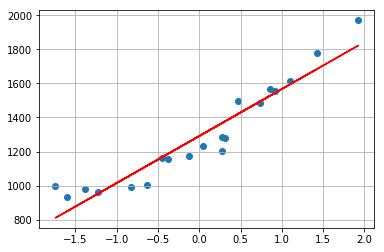

In [47]:
# グラフの描画
plt.scatter(train_x_std, train_y)
# 予測値
y_learned = learned_b + train_x_std * learned_w
# 回帰直線をプロット
plt.plot(train_x_std, y_learned, 'r')
plt.grid(True)
plt.show()

In [48]:
input_x = input('予測に使用する$x$の値を入力してください')

x = (int(input_x) - train_x.mean()) / train_x.std()

print(learned_b + x * learned_w)

予測に使用する$x$の値を入力してください300
1947.181503649442


---
# TensorFlowの数学関数

TensorFlowの数学関数は、オペレーションとしてデータフローグラフに追加できるように、オペレーション自体をTensorオブジェクトとして返す。

<img src="./imgs/TensorFlowの数学関数.png" width="70%">